# Introduction
This report showcases a preliminary set of possibilities that explore the concept of 'value in the fuel station network' for Z. One definition of 'Value' is the importance, worth, or usefulness of something. In the case of a fuel station network, we can break down 'value' to some high level aspects:

- Fuel station locations 
    - coverage

- Interactions of fuel stations with the environment
    - With Humans: accessibility, convenience
    - With Other entities (e.g. amenities like cafes, cinema theatres etc.): locale

- Fuel station characteristics: available amenities (e.g. toilets, fuel types, food etc.)

For a useful comparison, we need to further break down these high level aspects into proxy metrics, or quantitative analyses. The key differentiation between metrics and quantitative analyses is: metrics are simplistic, single number comparisons while quantitative analyses provide a more complex picture. For example, we can describe coverage with the following metrics:


Metric | Definition
--- | ---
Density| stations per unit area
Average spatial separation | typical distance between any two Z stations
Station connectivity | Z stations within a particular driving radius


Quantitative analyses of coverage include:
- Nearest neighbours of Z stations
    - The subset with competitor stations as their closest neighbours can be used to identify zones / regions with some level of user cannibalisation / poaching by competitor.
- Using the number of neighbours within a radius to identify the "important" / "centrally" located stations.

## Report Overview
The focus of this report is mainly on the *Coverage* aspect of fuel station value. A natural business question is:
> *Does Z have better coverage than their competitor(s) in Wellington? If so, how?*

The 'how' aspect will be analysed with:
- Average spatial separation between two fuel stations
- Station connectivity
- Nearest neighbour fuel stations: same brand or competitor 
- Driving accessibility 

The main competitor used for comparison is BP. The report will also include details of acquiring and cleaning spatial data. 

## Resources
I've used studies from urban data science as inspiration. Some resources I've consulted include:
- [Talk on Urban Data Science by Dr. Cecilia Mascolo](https://www.youtube.com/watch?v=eNpdvzORWVc&t=2162s)
- [Understanding Traffic with Open Data by researchers at Oxford Internet Institute](https://www.youtube.com/watch?v=0GM0sEvQ2-M)
- [Geoff Boening's blog - especially his package OSMnx](https://geoffboeing.com/2016/11/osmnx-python-street-networks/)
- [Proximity and accessibility analyses with Pandana](https://github.com/gboeing/urban-data-science/blob/master/20-Accessibility-Walkability/pandana-accessibility-demo-full.ipynb)

# Introduction to Spatial data
Spatial data includes geographical information for physical entities in our world. Since we're focusing on man-made entities like fuel stations, the simplest geographical information we require is geolocation. This information can be enriched with richer geography derived from the surrounding environment.    

## What spatial data do we need?
We need the following data to calculate the coverage metrics and do the quantitative analyses. The tools are described in more detail in the following section.

Data | Why? | How?
--- | --- | ---
Geo-tagged fuel stations | Base component of the spatial analyses. | Open Street Map via Overpass 
Regional map and street network | To connect the fuel stations via real world streets and roads. | Open Street Map via OSMnx

Open Street Maps (OSM) is the underlying data source. [OSM](https://en.wikipedia.org/wiki/OpenStreetMap) is an open, collaborative map of the world. In a later section, I will show how I've edited the available information on Wellington fuel stations. This editing feature will continue to be an important aspect - especially if we want to update the available services at the various fuel stations. 

The advantage of using OSM, other than enriching the available information for others, is that we can have the same framework providing data for Z as well as competitor brands. If we get the Z project, OSM will continue to play a key role because we won't be able to get information on competitors from Z. 

## Tools for spatial data analysis
This report is generated with Python 2.7. The packages highlighted below can be easily installed using a Python package manager like conda or pip.  

Tool | What does it do?
--- | ---
Overpass | [An API](https://wiki.openstreetmap.org/wiki/Overpass_API) to get data from OSM.
OSMnx | A python package that can analyse streets and roads with network algorithms.
Networkx | A python package to do standard network analysis when we don't require spatial information. 
Pandana | A python package for accessibility analyses. 


# Get Spatial data
This section is somewhat techincal. The specifics are not necessary to understand the analysis. 

In [42]:
# Import some packages
import warnings
import pandas as pd
import osmnx as ox 
import networkx as nx
import pandana as pa
import matplotlib.pyplot as plt
import utils.network_analysis as na
import utils.data_processing as dp

# Some configs
warnings.filterwarnings('ignore')
ox.config(log_console=True, use_cache=True)
pd.set_option('display.max_columns', 200)
#%matplotlib inline

## Set bounding box
The visual tool [here](http://boundingbox.klokantech.com/) is useful for getting the bounding box coordinates of the region we're interested in. I've chosen a bounding box that includes Wellington City and some of Lower Hutt. This selection underpins the rest of the report since only the entities *within* the bounding are used in the analysis. Another technical point to note is that bounding box conventions do vary. The Overpass API requires (W, S, E, N) while Pandana uses (S, W, N, E). I've explicitly labelled the bounding box for Pandana to avoid any confusion in the code. 
![](assets/bounding_box_selection.png)


In [2]:
# Define bounding box (W, S, E, N) for the area of Wellington we're interested in
bbox = [174.5813,-41.4552,175.0722,-41.1527]

# Separate out the bounding box list into 4 vertices. 
south = bbox[1]
west = bbox[0]
north = bbox[3]
east = bbox[2]

## Create Query
The following section creates a query to get fuel station data from Open Street Maps. The tags list can also be amended to get other amenities. The full list is [here](https://wiki.openstreetmap.org/wiki/Key:amenity). For example, we can easily get data for cafes and restaurants by adding these to the tags list.  

The Overpass API query is not very easy to read but the main components are: 
- The bounding box: the area where we want the search performed. 
- Data Primitives: ways, nodes, tags, relations.

The data primities of OSM have an intrinsic hierarchy with nodes being the root primitive. 
- Nodes: root primitive
- Ways: collection of nodes that defines a polygon (e.g. a building) or polyline (e.g. a road). 
- Relations: used for representing the relationship of existing nodes and ways
- Tags: Metadata stored as key-value pairs. 

The main primitives used in this report are nodes and tags. The nodes give the geolocation while we use the tags to filter specifically for fuel station nodes. More information about the entities of Open Street Maps can be found [here](https://en.wikipedia.org/wiki/OpenStreetMap#Operation). 

In [3]:
# What types of entitities do we want to get? Currently restricted to amenities
tags = ['fuel']
objects = ['node', 'way'] # like way, node, relation

# Generate the query string
compactOverpassQLstring = dp.generate_overpass_query(tags, objects, bbox)

## Getting data from Overpass 
Getting data from Open Street Map is fairly simple via the Overpass API. All you need to do is construct the search query and reshape the result JSON into your data structure of choice. I've reshaped the data as a Pandas dataframe - basically a table with columns that contain metadata about each fuel station. 

In [4]:
osmdf = dp.get_osm_data(compactOverpassQLstring)

In [5]:
# Isolate a subset of useful attributes per fuel station
sub_df = (osmdf[['id', 'lat', 'lon', 'name', 'operator', 'brand', 'type']]
          .sort_values(['lat', 'lon'])
          .reset_index()
          .drop(columns='index'))
sub_df.head(5)

,id,lat,lon,name,operator,brand,type
0,2845230323,-41.325288,174.810883,NaN,NaN,NaN,node
1,2845230324,-41.325284,174.811057,NaN,NaN,NaN,node
2,2845230322,-41.325275,174.810774,NaN,NaN,NaN,node
3,2845230321,-41.325200,174.810729,NaN,NaN,NaN,node
4,5821475056,-41.325128,174.810920,Z Broadway,NaN,Z,node


## Get Z Stations: Data Issues
We can query the Wellington fuel stations dataset to only get those that are associated with Z. The query returns 13 Z stations within the search region. From a cursory glance at the named Z stations and [the list from the website](https://bit.ly/2KEqu5m), we can see that there is considerable parity. We're missing Z Constable St but I believe the rest are there. Despite the close parity however, there are some issues with the data:
- Inconsistency between the operator and brand attributes. 
- No geolocation for some stations. 

![](assets/ways_without_geoloc.png)

The key problem with the data is that a significant portion of the stations don't have location coordinates. This problem, unfortunately stems from the two main types of OSM topological entities: ways and nodes. Depending on how a user marks out the location of a fuel station, the entity can be either a way or a node. 

- If the station is marked with a single point, the entity is a node with a clear geolocation. 
- If the station's perimeter / main building is traced out as a polygon, the entity is a way with no clear geolocation.  

## Resolving data issues
Since the underlying problem is a data issue, we can add / edit the data ourselves. You can sign up and verify your email as an OSM editor - quite easy to do. Once I got the permission to edit OSM, I simply went in and added / updated the nodes for the Z fuel stations. Later, I also updated the BP and Mobil stations in the Wellington bounding box used for the analysis. The corrected list of Z stations is now at parity with the Z website. 

In [6]:
# Show all Z stations labelled as a node. i.e. with geolocation 
z_stations = (sub_df.query('((brand == "Z")|(operator == "Z")) & (type == "node")')
              .reset_index()
              .drop(columns='index'))
z_stations

,id,lat,lon,name,operator,brand,type
0,5821475056,-41.325128,174.810920,Z Broadway,NaN,Z,node
1,3120151445,-41.320054,174.794407,Z Kilbirnie,NaN,Z,node
2,5821475059,-41.314924,174.813972,Z Miramar,NaN,Z,node
3,5821475061,-41.313163,174.781812,Z Constable Street,NaN,Z,node
4,5821475058,-41.297146,174.776556,Z Taranaki Street,NaN,Z,node
5,5544110098,-41.294501,174.774397,Z Vivian St,NaN,Z,node
6,5821475063,-41.281636,174.778417,Z Harbour City,NaN,Z,node
7,5821475060,-41.256020,174.765535,Z Crofton Downs,NaN,Z,node
8,2206248455,-41.236226,174.906171,Z Seaview,NaN,Z,node
9,331132009,-41.226300,174.806795,Z Johnsonville,NaN,Z,node


# Introduction to street network analysis

Having geolocation alone is not very useful beyond plotting points on a map. To know anything useful about the fuel station network, we need the roads connecting the fuel stations. In particular, we'd want to know about the best routes between the fuel stations. With this additional information, we have a trivial network structure: fuel station nodes connected by routes.

The package, OSMnx (a portmanteau acronym of Open Street Maps, OSM, and NetworkX, nx), is a great package for doing network anlysis with street data. The underlying representation used by this package is a reduction of streets and roads to edges with intersectionsas the vertices (or, nodes). This representation is also known as a 'Primal Graph'. The position of the nodes and the trajectory of the edges are further described with geolocation coordinates. The technical aspects are presented in [this paper](https://arxiv.org/pdf/1611.01890.pdf) by Geoff Boening: the author of OSMnx. 

With the OSMnx package, we can superimpose entities with geolocation on the spatial network. Once we've done this, we can find a path (route) connecting any two nodes. Because of the representation constraints, we don't find the route between the 2 specific entity coordinates (like Google Maps) - instead, we find the path between two nodes closest to the entities. 

The route between the nodes uses the edges (streets and roads) of the spatial network. The route calculation algorithm is an analogue of the [typical shortest path analyses done in network science](https://en.wikipedia.org/wiki/Shortest_path_problem). In a spatial network, the path length can be equated to distance. The base unit of length is metres. 

## Toy Example: route between Z Kilbirnie and Z Vivian St
The following example looks at the distance and route between two Z stations: Z Kilbernie and Z Vivian St. The red line in the figure is the shortest route that connects the two stations. From the street shapes, you can see that the route is wending it's way around Evans Bay and Basin Reserve, before entering the central city street grid. This route has a distance of 4.6 km - a value that corresponds quite closely to that given by [Google Maps](https://bit.ly/2Mvjr0L). 

In [7]:
# Get street network with a 5km radius around Z Kilbirnie
origin_point = tuple(z_stations.query('name == "Z Kilbirnie"')[['lat', 'lon']].values[0])
destination_point = tuple(z_stations.query('name == "Z Vivian St"')[['lat', 'lon']].values[0])
G = ox.graph_from_point(origin_point, distance=10000, distance_type='network', network_type='drive')

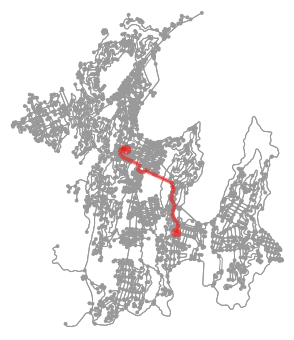

Text(0.5,1,'Shortest distance between Z Kilbirnie and Z Vivian St is 4577.443 m')

In [8]:
# Plot the route from the closest nodes to Z Kilbirnie and Z Vivian St
route, distance = na.get_shortest_path(origin_point, destination_point, G)
plot_title = "Shortest distance between Z Kilbirnie and Z Vivian St is {} m".format(distance)
fig, ax = ox.plot_graph_route(G, route)
ax.set_title(plot_title)

 ## Get street network for Wellington
 In the toy example, I only downloaded the street network within a 5km radius of Z Kilbirnie. For the main analysis though, we want all the streets and roads within the defined bounding box. The updated figure now shows the route between Z Kilbirnie and Z Vivian St overlayed on all the roads in the Wellington + Lower Hutt bounding box.  

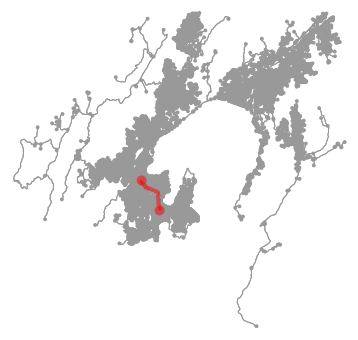

Text(0.5,1,'Shortest distance between Z Kilbirnie and Z Vivian St is 4268.96 m')

In [9]:
# Plot the route between Z Kilbinie and Z Vivian St on this larger area network
H = ox.graph_from_bbox(north, south, east, west, network_type='drive_service')
route, distance = na.get_shortest_path(origin_point, destination_point, H)
plot_title = "Shortest distance between Z Kilbirnie and Z Vivian St is {} m".format(distance)
fig, ax = ox.plot_graph_route(H, route)
ax.set_title(plot_title)

# Analysis: Average distance between Z stations in Wellington
The first analysis builds on the toy example to calculate the average distance between any two Z stations. A more academic name for this metric is: *average inter-station separation*. 

The procedure is to first calculate the route and distance between all possible pairs of the 13 Z stations in the region. The following table shows a subset of the results. We see distances from a bunch of Z stations to Z Broadway (in Strathmore). 

In [10]:
# Get pairwise shortest distances between all Z stations
z_stations_pairwise = na.get_pairwise_distances(z_stations, H)
z_pairwise_final = na.prettify_pairwise_distance_df(z_stations_pairwise, z_stations)
z_pairwise_final.head(5)

,distance,id_from,from,id_to,to
1,2822.644,3120151445,Z Kilbirnie,5821475056,Z Broadway
2,1332.762,5821475059,Z Miramar,5821475056,Z Broadway
3,4002.103,5821475061,Z Constable Street,5821475056,Z Broadway
4,5644.063,5821475058,Z Taranaki Street,5821475056,Z Broadway
5,5744.885,5544110098,Z Vivian St,5821475056,Z Broadway


Once we have 13x13 distances, we can get the closest station from every one of the 13 stations. A plot of the results shows that we have an asymmetric distribution of distances. A significant number clustered around 2km but also some which are more than twice the distance away. The average (both mean and median) inter-station separation is just over 2km 

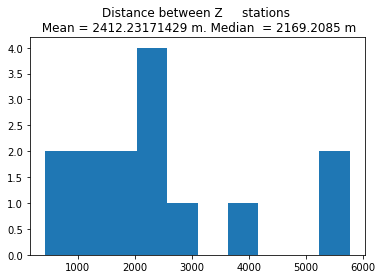

In [11]:
# Ordered list of distance to the closest Z station
closest_z_stations = z_pairwise_final.groupby('from')['distance'].agg('min')
na.plot_shortest_paths(z_pairwise_final)

# Analysis: Number of neighbours for Z stations
The same 13x13 table of distances can be used to analyse the number of neighbours for a Z station within a particular radius. For this analysis, I've recast the data into a network structure. The recasting is useful since we can use some standard network analysis tools available in the networkx package. 

The steps of the recasting are: 
- Filter the 13x13 distances to only include separations less than or equal to 10km. This step would remove the connection between Z Broadway and Z Petone for example. 
- Store the filtered distance matrix as a network data structure. This means:
    - 13 Z stations become nodes
    - Any Z station within 10km of each node becomes a connecting edge
    - The distance value is stored as a weight. With shorter distances have a higher 'weight'
    
We can now visualise this network structure. Some interesting insights include:
- 2 clusters are apparent in the Z station network for Wellington: Wellington City and Lower Hutt. 
- The Wellington City cluster is very tightly connected for the central and southern suburbs. 
- The connectivity of the Wellington City cluster reduces for the northern stations. The table of connections shows that stations in the southern suburbs are connected to two more stations than the northern suburbs and Lower Hutt. 

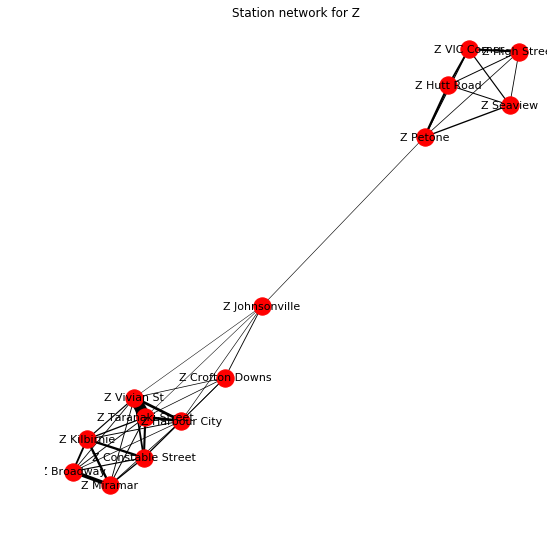

In [46]:
g = na.visualise_station_network(pairwise_df=z_pairwise_final)


The explicit connectivity of each Z station is given by a metric called 'degree' in network analysis. The degree distribution is a useful analysis for understanding characteristics of structure in larger &/ complex networks. Here, it's simply useful to use the node degree to understand the highly connected / central Z stations. As expected, these stations are the ones in the city centre: Z Harboour City, Z Vivian St, Z Taranaki Street.   

In [13]:
# Calculate unweighted degree (# connections for each Z station)
z_degree = na.station_degree(g)
z_degree

,station,degree
0,Z Harbour City,8
9,Z Vivian St,8
11,Z Taranaki Street,8
6,Z Constable Street,7
5,Z Miramar,6
8,Z Broadway,6
10,Z Kilbirnie,6
2,Z Crofton Downs,5
4,Z Petone,5
7,Z Johnsonville,5


# Competitor Analysis: Number of neighbours for BP stations
The same network analysis can be done for a competitor. I chose BP, since it *seems* to have a similar coverage to Z in the Wellington region. The network for BP shares some similar characteristics to the Z network but also has some obvious differences. 
- Wellington City and Lower Hutt clusters persist. 
- The northern suburbs are a little better connected. 
- The Wellington cluster is not as well connected as the Z station network. 
- The Lower Hutt cluster for BP is much better connected than Z. BP also has 2 more stations in Lower Hutt compared to Z. 

All these points indicate that while Z and BP cover similar areas of Wellington, *Z is better represented in Wellington City while BP dominates in Lower Hutt*. It would be very interesting to see if revenue per station is signficantly different for a Z station in Wellington City vs. Lower Hutt.  

In [14]:
# Get BP stations
bp_stations = (sub_df.query('((brand == "BP")|(operator == "BP")) & (type == "node")')
              .reset_index()
              .drop(columns='index'))
bp_stations_pairwise = na.get_pairwise_distances(bp_stations, H)
bp_pairwise_final = na.prettify_pairwise_distance_df(bp_stations_pairwise, bp_stations)

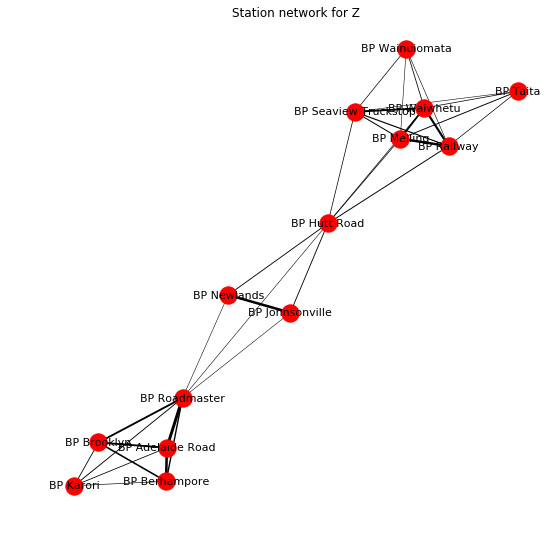

In [15]:
h = na.visualise_station_network(bp_pairwise_final)

# Comparative and joint analyses: Z vs. BP

The physical coverage of Z vs. BP stations using the inter-station separation continues to show the asymmetric distribution of separations. The key difference is that some BP stations are *much* better connected than others. The effect is more noticeable than for Z.

From this comparison, we can say that Z stations are better spread in the Wellington region compared to BP. We need to exercise some caution however; with only ~13 stations, we don't have much sample size. If we do a more complete analysis for Z, we can get robust statistics by running a hierarchical model for the average inter-station separation across the different types of regions. Until then, we just have to be mindful of how strongly we present this message. 

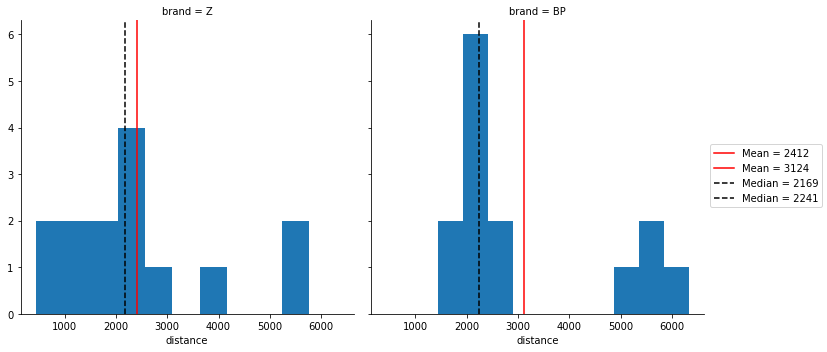

In [16]:
# Inter-station separation. Comparing Z and BP together
bp_pairwise_final['brand'] = 'BP'
z_pairwise_final['brand'] = 'Z'

pairwise_df_multibrand = pd.concat([bp_pairwise_final, z_pairwise_final])
na.plot_interstation_distance_multibrand(pairwise_df_multibrand)

## Nearest neighbours in Z- BP fuel station network

A key characteristic of good coverage is location in relation to other entities - especially competitors. A franchise should ideally be placed close to its own rather than near a competitor. A simple set of comparative analyses that explore the type pf nearest neighbour include:
- Seeing whether Z stations neighbour each other or a competitor
- Which Z stations are in a zone of poaching risk - i.e. their customers might go to a nearby competitor. 

For this analysis, we need to generate the shortest distances between all station pairs for *both* Z and BP stations together. The computation is not fast unfortunately so we definitely need to manage this calculation better for a larger dataset. Also, N.B. there is an implicit redundancy in the numbers cited above: some station pairs are each others nearest neighbours. 


In [17]:
# Join Z and BP station DFs. Have to reindex the composite dataframe.
z_stations['brand'] = 'Z'
bp_stations['brand'] = 'BP'

comp_z_bp = (pd.concat([z_stations, bp_stations])
             .reset_index()
             .drop(columns=['index']))
z_bp_stations = comp_z_bp[['id', 'name']]

# Generate pairwise distances
z_bp_stations_pairwise = na.get_pairwise_distances(comp_z_bp, H)
z_bp_pairwise_final = na.prettify_pairwise_distance_df(z_bp_stations_pairwise, z_bp_stations)

# Calculate closest stations (regardless of brand)
closest_z_bp_stations = na.interbrand_pairwise_distance_df(z_bp_pairwise_final)
closest_z_bp_stations.head()

,from,to,distance,from_brand,to_brand
19,BP Melling,Z VIC Corner,158.905,BP,Z
24,Z Johnsonville,BP Johnsonville,165.593,Z,BP
14,BP Johnsonville,Z Johnsonville,165.593,BP,Z
27,Z VIC Corner,BP Melling,185.207,Z,BP
4,Z Vivian St,Z Taranaki Street,436.455,Z,Z


In [41]:
print 'Out of {} Z and BP stations, \
{} are closest to a competitor and {} \
are next to one of their own'.format(len(closest_z_bp_stations),
                                     len(closest_z_bp_stations.query('from_brand != to_brand')), 
                                     len(closest_z_bp_stations.query('from_brand == to_brand')))

print 'Of the {} stations next to their own, \
{} are from Z'.format(len(closest_z_bp_stations.query('from_brand == to_brand')),
                      len(closest_z_bp_stations.query('(from_brand == to_brand) & (from_brand == "Z")')))

print 'Of the {} stations next to a competitor, \
{} are from Z'.format(len(closest_z_bp_stations.query('from_brand != to_brand')),
                      len(closest_z_bp_stations.query('(distance <= @median_z_bp_distance) &\
                                                       (from_brand != to_brand)')))


Out of 28 Z and BP stations, 19 are closest to a competitor and 9 are next to one of their own
Of the 9 stations next to their own, 8 are from Z
Of the 19 stations next to a competitor, 10 are from Z


In [18]:
closest_z_bp_stations.query('from_brand == to_brand')

,from,to,distance,from_brand,to_brand
4,Z Vivian St,Z Taranaki Street,436.455,Z,Z
7,Z Taranaki Street,Z Vivian St,438.123,Z,Z
0,Z Miramar,Z Broadway,1332.762,Z,Z
1,Z Broadway,Z Miramar,1332.762,Z,Z
2,Z Kilbirnie,Z Miramar,2111.346,Z,Z
16,Z Petone,Z Hutt Road,2227.071,Z,Z
18,Z High Street,Z VIC Corner,2356.524,Z,Z
9,Z Crofton Downs,Z Harbour City,5270.263,Z,Z
25,BP Wainuiomata,BP Waiwhetu,6335.055,BP,BP


Z stations with a BP station within the *average station-station separation distance* are at risk of having their users poached by the competitor. The list below shows that key poaching zones are: Johnsonville, Western / Central Hutt, Seaview, central Wellington and south-central Wellington (Newtown, Berhampore).  

In [19]:
median_z_bp_distance = closest_z_bp_stations['distance'].median()
closest_z_bp_stations.query('(distance <= @median_z_bp_distance) & (from_brand != to_brand)')

,from,to,distance,from_brand,to_brand
19,BP Melling,Z VIC Corner,158.905,BP,Z
24,Z Johnsonville,BP Johnsonville,165.593,Z,BP
14,BP Johnsonville,Z Johnsonville,165.593,BP,Z
27,Z VIC Corner,BP Melling,185.207,Z,BP
6,BP Roadmaster,Z Taranaki Street,729.384,BP,Z
11,BP Seaview Truckstop,Z Seaview,731.884,BP,Z
23,Z Seaview,BP Seaview Truckstop,748.029,Z,BP
5,BP Adelaide Road,Z Taranaki Street,1003.535,BP,Z
22,Z Harbour City,BP Roadmaster,1162.016,Z,BP
3,BP Berhampore,Z Constable Street,1351.750,BP,Z


## Driving accessibility analysis
The above analyses only consider the fuel stations and quantify implicit interactions between them. But we get the real benefit of spatial analyses when we consider interactions between the fuel stations and other entities - from humans to other businesses. One analysis of interaction is accessibility.  

Accessibility is a core analysis in urban planning. Some examples [here](https://www.slideshare.net/DimkaG/transitaccess-27460698). There are even tools which score regions with scores based on accessibility
e.g. [WalkScore](https://www.walkscore.com/). 

Here, we look at the driving distance in meters from each network node to the nearest POI (point of interest): a fuel station. It's possible to have many POIS. To do a visual acessibility analysis: 
- Break up the map into nodes 
- Calculate the distance from each node in the network to the POIS. 
- Visualise distance as a heatmap

All the above steps are carried out by the Python package Pandana. The specific steps are: 
- Download OSM data within the specified bounding box. 
- Convert map to nodes. Remember, this is easy since all OSM streets and roads are *ways* which are simply a collection of nodes. 
- Store node data in a convenient data structure: a Pandas dataframe. 
- Filter. 
- Calculate distance from each node to the POIS. 
- Plot distance as a heat map. How to do nth nearest amenity??


In [47]:
# Set some parameters for accessibility analysis
n = 1 # nth closest nodes to fuel station. n = 1 means the closest.
distance = 5000.0
num_pois = 10

# Plotting parameters
bbox_aspect_ratio = 2
fig_kwargs = {'facecolor':'w', 
              'figsize':(10, 10 * bbox_aspect_ratio)}
plot_kwargs = {'s':5, 
               'alpha':0.9, 
               'cmap':'viridis_r', 
               'edgecolor':'none'}

In [48]:
# Generate accessibility network
network, pandana_bbox = na.get_pandana_network(bbox, tags)
z_accessibility = na.get_accessibility(network, z_stations, distance=distance, num_pois=num_pois)
bp_accessibility = na.get_accessibility(network, bp_stations, distance=distance, num_pois=num_pois)

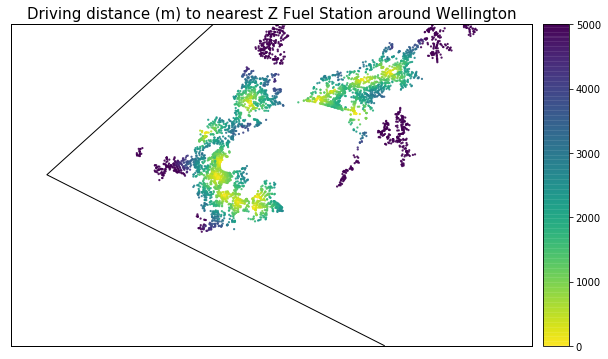

In [49]:
# Plot driving accessibility for Z stations
na.plot_accessibility(network, z_accessibility[n], pandana_bbox, 
                      fig_kwargs=fig_kwargs, plot_kwargs=plot_kwargs)

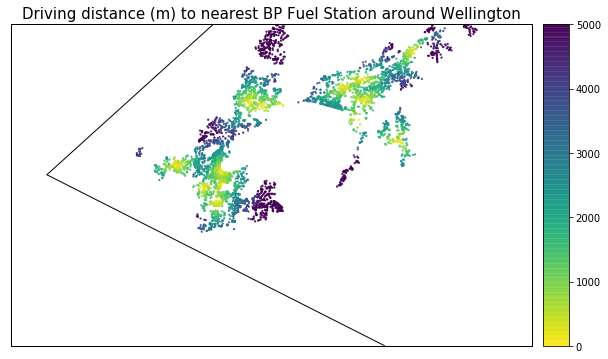

In [50]:
# Plot driving accessibility for BP stations
na.plot_accessibility(network, bp_accessibility[n], pandana_bbox, 
                      amenity_type='BP Fuel Station', 
                      fig_kwargs=fig_kwargs, plot_kwargs=plot_kwargs)